#Settings

In [618]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [619]:
#Needed to use cv2.xfeatures2d.SIFT_create() in Segmentation section
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [620]:
import os
##########################################################
# SHOULD CHANGE THE PATH WHERE YOU PUT THE SHARED DRIVE!
# SHARED_DRIVE_LOCATION = 'Academic/2020 Fall/EECS 504/' # Muti
SHARED_DRIVE_LOCATION = '/content/drive/MyDrive' # Thomas #Junhwan
##########################################################
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = os.path.join(SHARED_DRIVE_LOCATION, '504_project/')
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
# print(os.listdir(GOOGLE_DRIVE_PATH))

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time
os.environ["TZ"] = "US/Eastern"
time.tzset()

import glob

%cd {os.path.join('/content', GOOGLE_DRIVE_PATH)}
%ls

/content/drive/.shortcut-targets-by-id/1aDjp-r3-uoqcu-Kzpsu2w2K7MS9dAy7S/504_project
 Brainstorm.gdoc                            'Project Proposal.gdoc'
'Copy of Final Project.ipynb'               'Retailer Photos'/
'Final Project.ipynb'                        Segmentation/
'Final Project Presentation Video.gslides'   shoe_detection/
'Meeting Minutes'/                           Stitching/
'Project PPT.pptx'                          'User Photos'/


#Input Paths

In [621]:
user_path = "User Photos/left_right_01.jpg"  #works 1/2 (detection problem)
user_path = "User Photos/left/left21.jpg"
user_path = "User Photos/right/right30.jpg" #works well 2/2
user_path = "User Photos/left/left09.jpg"
user_path = "User Photos/left/left01.jpg"
user_path = "User Photos/right/right36.jpg"
user_path = "User Photos/right/right37.jpg"
# "User Photos/right/right10.jpg" #works 0/2 (segmentation problem)
# "User Photos/left_right_01.jpg" #works 2/3 (stitching problem)
# "User Photos/right/right18.jpg" #works 1/2 (stitching problem)
retail_right_path = "Retailer Photos/Shuoqi Wang/NIKE/37/right.jpg"
retail_left_path = "Retailer Photos/Shuoqi Wang/NIKE/37/left.jpg"
retail_right_path = "Retailer Photos/Nam Gyu Kil/Adidas/fx2044_black/right.jpg"
retail_left_path = "Retailer Photos/Nam Gyu Kil/Adidas/fx2044_black/left.jpg"
retail_right_path = "Retailer Photos/Nam Gyu Kil/Adidas/zx_2k_orange/right.jpg"
retail_left_path = "Retailer Photos/Nam Gyu Kil/Adidas/zx_2k_orange/left.jpg"
retail_right_path = "Retailer Photos/Nam Gyu Kil/Adidas/kaptir_black/right.jpg"
retail_left_path = "Retailer Photos/Nam Gyu Kil/Adidas/kaptir_black/left.jpg"
retail_right_path = "Retailer Photos/Nam Gyu Kil/Adidas/nmd_r1_v2_pink/right.jpg"
retail_left_path = "Retailer Photos/Nam Gyu Kil/Adidas/nmd_r1_v2_pink/left.jpg"
retail_right_path = "Retailer Photos/Nam Gyu Kil/Adidas/stan_smith_red/right.jpg"
retail_left_path = "Retailer Photos/Nam Gyu Kil/Adidas/stan_smith_red/left.jpg"
retail_right_path = "Retailer Photos/Nam Gyu Kil/Adidas/busenitz_pro_black/right.jpg"
retail_left_path = "Retailer Photos/Nam Gyu Kil/Adidas/busenitz_pro_black/left.jpg"


# 1. Shoes Detection
### Input: User Image
### Output: Cropped Image, Bounding Image

In [622]:
%cd shoe_detection/

from __future__ import division

from models import Darknet
# from models import *
from utils.utils import *
from utils.datasets import *
from utils.nms_footwear import *

import os
import sys
import time
import datetime
import argparse

from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator


def detect_shoes(image_jpeg, conf_thres=0.1, nms_thres=0.4, box_extension=0):
    '''Detect shoes in an image.
    Given an image, detect where the shoes are and output the bounding box coordinates,
    class confidence scores and confidence score.
    Input:
    - img_jpeg: image data read from Image.open(img_path).
    - conf_thres: confidence score threshold. Float.
    - nms_thres: threshold for non maximum suppression.
    Output:
    - croppend images?
    - bounding box coordinates
    - confidence scores
    '''
    model_def = 'shoe_detection/config/yolov3-openimages.cfg'
    weights_path = 'shoe_detection/config/yolov3-openimages.weights'
    class_path = 'shoe_detection/config/oidv6.names'
    conf_thres = 0.1
    nms_thres = 0.4
    batch_size = 1
    n_cpu = 0
    img_size = 416


    # Extract image as PyTorch tensor
    img_np = np.array(image_jpeg)

    img_tnsr = transforms.ToTensor()(image_jpeg)
    img_shape_original = torch.tensor(img_tnsr.shape)[[1,2,0]]

    # Pad to square resolution
    img, _ = pad_to_square(img_tnsr, 0)
    # Resize
    img = resize(img, img_size)
    img = img.unsqueeze_(0)

    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set up model
    model = Darknet(model_def, img_size=img_size).to(device)
    model.load_darknet_weights(weights_path)

    model.eval()  # Set in evaluation mode
    classes = load_classes(class_path)  # Extracts class labels from file
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
    input_imgs = Variable(img.type(Tensor))

    # Get detections
    with torch.no_grad():
        detections = model(input_imgs) # (B, A, )
        detections = non_max_suppression_for_footwear(detections, conf_thres, nms_thres)[0]

    if detections is not None:
        detections = rescale_boxes(detections, img_size, img_shape_original[:2])
        cropped_imgs = []
        bbox_coords = []
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            x1 = round(x1.item()) - box_extension
            y1 = round(y1.item()) - box_extension
            x2 = round(x2.item()) + box_extension
            y2 = round(y2.item()) + box_extension
            # cropped_imgs.append(img_tnsr[:, x1:x2, y1:y2])
            cropped_imgs.append(img_np[y1:y2, x1:x2, :])
            bbox_coords.append([x1,y1,x2,y2])
        return cropped_imgs, bbox_coords
    else:
        return None, None

%cd ..

/content/drive/.shortcut-targets-by-id/1aDjp-r3-uoqcu-Kzpsu2w2K7MS9dAy7S/504_project/shoe_detection
/content/drive/.shortcut-targets-by-id/1aDjp-r3-uoqcu-Kzpsu2w2K7MS9dAy7S/504_project


ValueError: ignored

<Figure size 432x288 with 0 Axes>

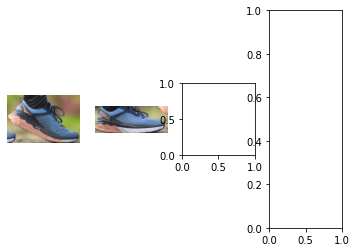

In [623]:
img_path = user_path
img = Image.open(img_path)
cropped_imgs, bbox_coords = detect_shoes(img)

plt.figure()
if len(cropped_imgs) > 1:
  fig, ax = plt.subplots(1, len(cropped_imgs))
  for i, img_ in enumerate(cropped_imgs):
      ax[i].imshow(img_)
      ax[i].set_axis_off()
else:
  plt.axis('off')
  plt.imshow(cropped_imgs[0])

# 2. Segmentation

## Retail Photo Segmentation
### Input: Retail Image
### Output: Mask of the Shoes

In [ ]:
def retail_segment(image_path):
  shoes = plt.imread(image_path)/255
  shoes = shoes[:,:,:3]
  ind_shoes = np.where(np.all(shoes == shoes[0,0], axis=-1))
  ind_not_shoes = np.where(np.all(shoes != shoes[0,0], axis=-1))
  mask_shoes = np.copy(shoes)
  mask_shoes[ind_shoes[0], ind_shoes[1],:] = 0
  mask_shoes[ind_not_shoes[0], ind_not_shoes[1],:] = 1
  return mask_shoes

In [ ]:
img_path = retail_right_path
img_retail_seg = retail_segment(img_path)
plt.imshow(img_retail_seg)

Alternative Method:


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy
from skimage import segmentation
from skimage import io, color
import skimage

def cluster_centers(superpixel_map):
  x_centers = np.zeros(len(np.unique(superpixel_map)))
  y_centers = np.zeros_like(x_centers)
  counts = np.zeros_like(x_centers)
  rows, cols = superpixel_map.shape

  for row in range(rows):
    for col in range(cols):
      x_centers[superpixel_map[row, col]] += col
      y_centers[superpixel_map[row, col]] += row
      counts[superpixel_map[row, col]] += 1

  x_centers = np.round(x_centers/counts).astype('int')
  y_centers = np.round(y_centers/counts).astype('int')
  centers = list(zip(y_centers, x_centers))

  return centers

def apply_supermap(img, superpixel_map):
  centers = cluster_centers(superpixel_map)
  out = np.copy(img)
  for i,(row, col) in enumerate(centers):
    if img[row,col,0] > 0.92 and img[row,col,1] > 0.92 and img[row,col,2] > 0.92 and img[row,col,0] == img[row,col,1] and img[row,col,2] ==img[row,col,1]:
      out[superpixel_map == i] = [1,1,1]
    else:
      out[superpixel_map == i] = [0,0,0]
  return out



In [ ]:
from PIL import Image

left = plt.imread(retail_left_path)/255
left = left[:,:,:3]
super_left = segmentation.slic(left, n_segments=82, compactness=30, max_iter=20)
right = plt.imread(retail_right_path)/255
right = right[:,:,:3]
super_right = segmentation.slic(right, n_segments=82, compactness=30, max_iter=20)
fig, ax = plt.subplots(2, 3, figsize=(8,8))
images = [left, right]
maps = [super_left, super_right]
for i,a in enumerate(ax):
  a[0].set_axis_off()
  a[0].set_title('Original', fontsize=10)
  a[0].imshow(images[i])
  a[1].set_axis_off()
  a[1].set_title('Superpixel map', fontsize=10)
  a[1].imshow(skimage.color.label2rgb(maps[i]))
  a[2].set_axis_off()
  a[2].set_title('Shoe Mask', fontsize=10)
  a[2].imshow(apply_supermap(images[i], maps[i]))

## User Photo Segmentation
### Input: Image, Cropped Image, Bounding Box
### Outut: Mask of the Shoes

In [ ]:
#!pip install opencv-python==3.4.2.16
#!pip install opencv-contrib-python==3.4.2.16

In [ ]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from skimage.draw import polygon
import cv2 as cv
import pdb 

def user_segment(img, b_super=False, b_blur=False, blur=15):
  if b_super == True:
    super_img = segmentation.slic(img, n_segments=10000, compactness=15, max_iter=20)
    img = apply_supermap(img, super_img)
  # SIFT
  gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  sift  = cv.xfeatures2d.SIFT_create()
  keypoints,descriptors = sift.detectAndCompute(gray,None)   #calculate keypoints and their orientation
  # Convex
  pts = np.zeros((len(keypoints),2))
  for i in range(len(keypoints)):
    pts[i,0] = int(keypoints[i].pt[0])
    pts[i,1] = int(keypoints[i].pt[1])
  # Convex Hull
  hull = ConvexHull(pts, True)
  hull_indices = hull.vertices
  new_x, new_y = polygon(pts[hull_indices,0],pts[hull_indices,1])
  # Grab Cut
  mask = np.ones(img.shape[:2],np.uint8) * 2
  mask[new_y, new_x] = 3
  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)
  rect = (1,1,img.shape[0]-1,img.shape[1]-1)
  if b_blur == True:
    img = cv.GaussianBlur(img,(blur,blur),0)
    # img = cv.bilateralFilter(img,9,75,75)
  cv.grabCut(img,mask,rect,bgdModel,fgdModel,10,cv.GC_INIT_WITH_MASK)
  mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
  return mask2

In [ ]:
img_user_seg = cropped_imgs[1]
mask = user_segment(img_user_seg)
#img_user_seg = img*mask[:,:,np.newaxis]
plt.imshow(mask, cmap = 'gray')

# 3. Stitching
### Input: User Image, Cropped Images, Bounding Boxes, Retailer Images, Mask of User and Retailer Shoes
### Output: User Photo with Retailer Shoes Stitched

## Photo Class used for Stitching

In [ ]:
import numpy as np
import cv2
import copy

class Photo:
  inv_val = -1

  def __init__(self, photo, seg_map, name="NoName"):
    self.original = photo
    self.seg_map = seg_map
    self.height, self.width, self.channel = photo.shape
    self.name = name  
  

  def add_padding(self, final_height, final_width):
    self.pad_left = (final_width - self.width)//2
    self.pad_right = final_width - self.width - self.pad_left
    self.pad_top = (final_height - self.height)//2
    self.pad_bottom = final_height - self.height - self.pad_top
    
    self.padded = cv2.copyMakeBorder(self.original,
                                    self.pad_top,self.pad_bottom,self.pad_left,self.pad_right,
                                    cv2.BORDER_CONSTANT,value=[0,0,0])
    
    self.seg_map = self.seg_map.astype('float32')
    self.padded_seg_map = cv2.copyMakeBorder(self.seg_map,
                                             self.pad_top,self.pad_bottom,self.pad_left,self.pad_right,
                                             cv2.BORDER_CONSTANT,value=[0])
    
    self.padded_height = final_height
    self.padded_width = final_width


  def largest_eigvec(self):
    #create 2 x N array
    Y, X = self.seg_map.nonzero() # (row# = Y) (col# = X)
    coords = np.zeros((2, len(X)))
    coords[0, :] = np.array(X)
    coords[1, :] = np.array(Y)
    avg = np.mean(coords, axis=1)
    coords = coords - avg.reshape(2, 1) #make it 0-mean

    u, s, vh = np.linalg.svd(coords, full_matrices=False)
    largest = np.argmax(s) #index of largest eigval
    self.eigvec = u[largest, :] #largest eigval for covarianace matrix (row of U)

    if self.eigvec[0] < 0: #also in largest_eigvec function, but for atomicity/redundancy
      self.eigvec *= -1

    return self.eigvec
  

  def _get_rotation_mat(self, alternative = False):
    #two different rotation is possible since we are matching a line to a line
    #use alternative= True/False to get both orientation matchings
    eigvec = self.largest_eigvec()
    if eigvec[0] < 0: #also in largest_eigvec function, but for atomicity/ redundancy
      eigvec *= -1
    if alternative:
      eigvec = -1*eigvec
    ax_vec = np.array([1,0])
    theta = np.arccos(np.dot(eigvec, ax_vec))
    direction = np.sign(eigvec[1])
    if alternative:
      self.angle_alt = direction*theta*180/np.pi
      return cv2.getRotationMatrix2D((self.padded_width/2,self.padded_height/2), self.angle_alt, 1)
    else:
      self.angle = direction*theta*180/np.pi
      return cv2.getRotationMatrix2D((self.padded_width/2,self.padded_height/2), self.angle, 1)
  

  def _rotate_seg_map(self, seg_map, transform_m, is_homography=False):
    tmp_seg = copy.deepcopy(seg_map).astype('float32')
    if is_homography:
      tmp_seg = cv2.warpPerspective(tmp_seg, transform_m, (self.padded_width, self.padded_height))
    else:
      tmp_seg = cv2.warpAffine(tmp_seg, transform_m, (self.padded_width, self.padded_height))
    return tmp_seg


  def align_eigvec(self, alternative = False):
    rotation_M = self._get_rotation_mat(alternative)
    if alternative:
      self.oriented_alt = cv2.warpAffine(self.padded, rotation_M, (self.padded_width, self.padded_height))
      self.seg_oriented_alt = self._rotate_seg_map(self.padded_seg_map, rotation_M)
    else:
      self.oriented = cv2.warpAffine(self.padded, rotation_M, (self.padded_width, self.padded_height))
      self.seg_oriented = self._rotate_seg_map(self.padded_seg_map, rotation_M)
  

  def _find_bbox(self, alternative = False):
    Y, X = None, None
    if alternative:
      Y, X = self.seg_oriented_alt.nonzero()
    else:
      Y, X = self.seg_oriented.nonzero()
    leftmost = np.min(X)
    rightmost = np.max(X)
    topmost = np.max(Y)
    bottommost = np.min(Y)
    return topmost, bottommost, leftmost, rightmost


  def contour_slices(self, alternative = False, num_slices = 10):
    tmp_seg = None
    if alternative:
      seg_map = self.seg_oriented_alt
    else:
      seg_map = self.seg_oriented
    
    topmost, bottommost, leftmost, rightmost = self._find_bbox(alternative)

    #use empty array instead of fixed size so that slices with no intersection can be left out
    X = [] 
    Y = []
    h_interval = (rightmost-leftmost)/(num_slices+1) #double
    for i in range(num_slices):
      slice_pos = int(leftmost + h_interval*(i+1)) #integer value
      y_vals = seg_map[:, slice_pos].nonzero()[0]
      if y_vals.size == 0:
        #insert inv_val so that datapoints that should have
        #corresponded to this slice can be disregarded from the other image
        X.append(Photo.inv_val)
        Y.append(Photo.inv_val)
        X.append(Photo.inv_val)
        Y.append(Photo.inv_val)
        continue
      X.append(slice_pos)
      Y.append(np.min(y_vals)) #lowest contour intersection
      X.append(slice_pos)
      Y.append(np.max(y_vals)) #highest contour intersection
    
    #fewer slices since sneakers are more wide than tall
    num_slices //= 2
    v_interval = (topmost-bottommost)/(num_slices+1) #double
    X_h = np.zeros(num_slices*2)
    Y_h = np.zeros(num_slices*2)
    for i in range(num_slices):
      slice_pos = int(bottommost + v_interval*(i+1)) #integer value
      x_vals = seg_map[slice_pos, :].nonzero()[0]
      if x_vals.size == 0:
        X.append(Photo.inv_val)
        Y.append(Photo.inv_val)
        X.append(Photo.inv_val)
        Y.append(Photo.inv_val)
        continue
      Y.append(slice_pos)
      X.append(np.min(x_vals)) #leftmost contour intersection
      Y.append(slice_pos)
      X.append(np.max(x_vals)) #rightmost contour intersection

    X = np.array(X)
    Y = np.array(Y)

    if alternative:
      self.X_alt, self.Y_alt = X,Y
    else:
      self.X, self.Y = X,Y

    return X, Y
  

  def homography_transform(self, homography_m):
    self.transformed = cv2.warpPerspective(self.oriented, homography_m, (self.padded_width, self.padded_height))
    self.seg_transformed = self._rotate_seg_map(self.seg_oriented, homography_m, True)
  

  def affine_transform(self, affine_m):
    self.transformed = cv2.warpAffine(self.oriented, affine_m, (self.padded_width, self.padded_height))
    self.seg_transformed = self._rotate_seg_map(self.seg_oriented, affine_m)


  def stitch_n_crop(self, other_photo, transform_m, is_homography=False, alternative=False, filter = False):
    #if filter = True, mask using current photo's segmentation map to account for occlusion (optional)

    #added because we need other_photo.transformed to be most up to date every time
    #stitch_n_crop is called
    if is_homography:
      other_photo.homography_transform(transform_m)
    else:
      other_photo.affine_transform(transform_m)

    #rotate other_photo to this photo's original orientation
    reverse_rot_M = None
    if alternative:
      reverse_rot_M = cv2.getRotationMatrix2D((self.padded_width/2,self.padded_height/2), -self.angle_alt, 1) #Note: negative angle
    else:
      reverse_rot_M = cv2.getRotationMatrix2D((self.padded_width/2,self.padded_height/2), -self.angle, 1) #Note: negative angle
    other_complete = cv2.warpAffine(other_photo.transformed, reverse_rot_M, (self.padded_width,self.padded_height))
    other_seg_complete = self._rotate_seg_map(other_photo.seg_transformed, reverse_rot_M)

    #crop out padding
    other_complete = other_complete[self.pad_top:self.pad_top+self.height, self.pad_left:self.pad_left+self.width, :]
    other_seg_complete = other_seg_complete[self.pad_top:self.pad_top+self.height, self.pad_left:self.pad_left+self.width] != 0
    #other_seg_complete needs != 0 because not all values in segmentationmap are 0/1's due to homography transformation and rotation

    #paste it current photo
    self.complete = copy.deepcopy(self.original)
    for i in range(self.channel):
      if filter:
        self.complete[:,:,i][(other_seg_complete != 0) & (self.seg_map != 0)] = other_complete[:,:,i][(other_seg_complete != 0) & (self.seg_map != 0)]
      else:
        self.complete[:,:,i][other_seg_complete] = other_complete[:,:,i][other_seg_complete]
    
    return copy.deepcopy(self.complete), other_seg_complete

##Stitching

In [ ]:
retail_paths = [retail_right_path, retail_left_path]
retail_names = ["right", "left"]
retail_lst = [] #list of retail Photo class

for path, name in zip(retail_paths, retail_names):
  img = plt.imread(path)
  seg = retail_segment(path)[:,:,0]
  retail_lst.append(Photo(img, seg, name=name))

In [ ]:
user_photo = plt.imread(user_path) #user photo which stitchings will be accumulated
user_photo = copy.deepcopy(user_photo)

#cropped_imgs, bbox_coords = detect_shoes(user) #already ran in section 1

#Considers upside down orientations when including True
alternative_lst = [True, False]

for i, (user_shoe, bbox) in enumerate(zip(cropped_imgs, bbox_coords)):
  user_seg = user_segment(user_shoe)

  #prevent bad segmentations from overwriting good stitchings/ break code
  seg_size_threshold = 0.3 #min percentage shoe must take up of the bounding box
  if np.sum(user_seg != 0) / user_seg.size < seg_size_threshold:
    continue

  user = Photo(user_shoe, user_seg)

  #################
  #Pad images to make all the same sizes
  #################
  #find largest width and height
  max_height, max_width = 0,0

  for retail in retail_lst:
    max_height = max(max_height, retail.height)
    max_width = max(max_width, retail.width)
  max_height = max(max_height, user.height)
  max_width = max(max_width, user.width)

  #pad retail photos
  for retail in retail_lst:
    retail.add_padding(max_height, max_width)
  #pad user photo
  user.add_padding(max_height, max_width)


  #################
  #Align shoes by their largest eigenvector
  #Then slice their contours
  #################
  num_slices = 20
  for retail in retail_lst:
    retail.align_eigvec()
    retail.contour_slices(num_slices = num_slices)
  for alt in alternative_lst:
    user.align_eigvec(alt)
    user.contour_slices(num_slices = num_slices, alternative = alt)

  #################
  #Pick best matching similarity and homography transform 
  #using RANSAC and least squares error
  #################
  transform_types = ["similarity", "homography"]
  min_homography_tuple = () #retail, alt(True/False), homography_m
  min_similarity_tuple = () #retail, alt(True/False), affine_m
  for t_type in transform_types:
    min_cost = math.inf
    max_inliers = 0
    for retail in retail_lst:
      retail_contour_X, retail_contour_Y = retail.X, retail.Y
      src = np.vstack((retail_contour_X, retail_contour_Y)).T
      for alt in alternative_lst:
        user_contour_X, user_contour_Y = None, None
        if alt:
          user_contour_X, user_contour_Y = user.X_alt, user.Y_alt
        else:
          user_contour_X, user_contour_Y = user.X, user.Y

        #find transformation matrix
        dst = np.vstack((user_contour_X, user_contour_Y)).T
        transform_m, inliers = None, None
        src_filtered = src[dst != Photo.inv_val].reshape((-1, 2))
        dst_filtered = dst[dst != Photo.inv_val].reshape((-1, 2))
        if t_type == "homography":
          transform_m, inliers = cv2.findHomography(src_filtered, dst_filtered)
        elif t_type == "similarity":
          transform_m, inliers = cv2.estimateAffinePartial2D(src_filtered, dst_filtered)
        inliers_mask = np.vstack((inliers, inliers)).reshape(2, -1) == 1

        #calculate cost = sum(||Hx-y||^2)
        src_3D = np.vstack((src_filtered.T, np.ones(len(src_filtered))))
        mapped = np.matmul(transform_m, src_3D)
        if t_type == "homography":
          mapped[0, :] = mapped[0, :] / mapped[2, :]
          mapped[1, :] = mapped[1, :] / mapped[2, :]
        dst_filtered = dst_filtered.T
        cost = np.sum((mapped[:2, :][inliers_mask] - dst_filtered[inliers_mask])**2)
        num_inliers = np.count_nonzero(inliers)

        #pick first by num_inliers, then by cost
        if cost < min_cost and max_inliers <= num_inliers:
          if t_type == "homography":
            min_homography_tuple = (retail, alt, transform_m)
          elif t_type == "similarity":
            min_similarity_tuple = (retail, alt, transform_m)
          min_cost = cost
          max_inliers = num_inliers
        #print("user_{}".format(i), t_type, retail.name, alt, cost, num_inliers)

  #################
  #Pick the better matching transformation to apply
  #based on stitching results
  #################
  retail_h, alt_h, homography_m = min_homography_tuple
  homography_final, homography_seg = user.stitch_n_crop(retail_h, homography_m, is_homography=True, alternative=alt_h)

  retail_a, alt_a, affine_m = min_similarity_tuple
  affine_final, affine_seg = user.stitch_n_crop(retail_a, affine_m, alternative=alt_a) # this affect user's member vairables

  #pick the option where retail segmentaion covers more of user segmentation
  better_option = ""
  final = None
  overlap_count = 0
  if np.count_nonzero(user.seg_map[homography_seg]) < np.count_nonzero(user.seg_map[affine_seg]):
    better_option = "similarity"
    final = affine_final
    overlap_count = np.count_nonzero(user.seg_map[affine_seg])
  else:
    better_option = "homography"
    final = homography_final
    overlap_count = np.count_nonzero(user.seg_map[homography_seg])
  #print(better_option)

  #decide to filter by user segmentation if retail overflows by a certain threshold
  #i.e. (overlap between segmentations) / (retail segementation size) < threshold
  threshold = 0.8
  if better_option == "similarity" and overlap_count/ np.count_nonzero(affine_seg) < threshold:
    final, _ = user.stitch_n_crop(retail_a, affine_m, alternative=alt_a, filter=True)
  elif better_option == "homography" and overlap_count/ np.count_nonzero(homography_seg) < threshold:
    final, _ = user.stitch_n_crop(retail_h, homography_m, is_homography=True, alternative=alt_h, filter=True)

  #################
  #paste the stitched image back to the larger user photo
  #################
  x1,y1,x2,y2 = bbox
  user_photo[y1:y2, x1:x2] = final

#4. Visualize Final Result

In [ ]:
original = plt.imread(user_path)

rows, cols, _ = original.shape
fig, ax = plt.subplots(1,2, figsize=(cols//30,rows//30))
ax[0].imshow(original)
ax[1].imshow(user_photo)
for x in ax:
  x.set_axis_off()
plt.show()